# Identifying Themes in Anthony Bourdain's *Parts Unknown* 

## Using Non-negative Matrix Factorization and K-Means Clustering To Cluster Television Transcripts

### And also planning my next vacation...

Like many travelers I was deeply saddened by the death of travel personality Anthony Bourdain. An ongoing (and ridiculous) theme that I foist on those around me is pretending that Bourdain 'stole' my favorite places. "Pfffff, he **WOULD** go to Armenia," I whine. But in reality, I greatly valued the always interesting and above all wonderfully humanistic viewpoint that Bourdain presented while exploring the world's contentious and complex places. I'll miss this viewpoint terribly, and in this project I applied NLP and clustering tools to identify overarching themes in Bourdain CNN televsion series *Parts Unknown*. 

## Data Sources

I downloaded transcripts of the television show *Parts Unknown* from [OpenSubtitles](https://www.opensubtitles.org) and from [CNN](http://www.cnn.com/TRANSCRIPTS/abpu.html). Neither data source contained transcripts of all expisodes so I needed to use two different sources.

## Data Extraction and Formatting

My initial processing of transcripts from the two sources was tailored to the unique structure of the two transcript file types. For the OpenSubtitle files I processed with a modified script [here](https://gist.github.com/ndunn219/62263ce1fb59fda08656be7369ce329b) (modifications saved as the subtitle_lib module in this repo) and filtered the text to remove the intro theme song. For the CNN files, I used regex to remove narration indicators and a common 'transcript' words (things like 'translator' and 'voice-over') that appeared in this format.

After initial processing, both file types were combined into a data frame containing episode information and the full transcript text. You can find the full data set (including additonal meta data like episode air date and location) on my GitHub repo [here](add link to csv).

In [366]:
import nltk
import os, os.path
import pandas as pd
import glob
import re
import numpy as np
import math

# import python module to clean transcripts
from subtitle_lib.srt_formatting import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Extraction

In [ ]:
# make list of full directory path names for each season

path = os.getcwd() + '/puk_data/'
dirs = os.listdir(path)
dirs.remove('.DS_Store')
dirs.remove('cnn_transcripts') # remove CNN transcripts from this processing step

full_dirs = []
for file in dirs:
    full_dir = path + file
    full_dirs.append(full_dir)

In [ ]:
# make list of full episode path names for each episode of each season

episode_files = []
for file in full_dirs:
    contents = (glob.glob('{}/*'.format(file)))
    for episode in contents[:(len(contents))]:
        episode_srt = (glob.glob('{}/*'.format(episode)))
        episode_files.append(episode_srt[0])

In [ ]:
# function to call cleaning scripts (from subtitle_lib.srt module) and write cleaned file as txt
# this function is for the open subtitles files in the .srt format

def clean_save_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-28:-22] + '.txt'
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [ ]:
# call cleaning function on each episode, save to file

for episode in episode_files:
    clean_save_file(episode)

In [7]:
# cleaning function for transcripts from CNN (not open subtitles)

def clean_save_CNN_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-10:]
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [8]:
# make full file name of new episodes

CNN_episode_paths = []
for item in os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'):
    CNN_episode_paths.append((os.getcwd() + '/puk_data/cnn_transcripts/') +item)

# call CNN cleaning function for new episodes

for episode in CNN_episode_paths:
    clean_save_CNN_file(episode)

#### Saving Parsed Text Files to DF

In [3]:
# make list of full directory path names for each season

path = os.getcwd() + '/processed_text/'
files = os.listdir(path)
files.remove('.DS_Store') 
files.remove( '.480p..txt') # not sure what this file is, doesn't appear in file browser, removed
files.remove( '.S06E0.txt') # ditto

full_file_paths = [path + f for f in files] # create full file paths

In [4]:
# get subtitle text from each episode file

episode_list = [] # append tuple of episodeID and subtitle text to list

for f in full_file_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [9]:
# get CNN text from each CNN episode file

CNN_episode_list = [] # append tuple of episodeID and subtitle text to list

for f in CNN_episode_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    CNN_episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [10]:
complete_episodes = episode_list

In [11]:
# append episodeID and subtitle text data to df
puk = pd.DataFrame.from_records(complete_episodes)
puk.columns=['episodeID', 'text']

#### Adding episode metadata to DF

In [16]:
# read in csv with episode location information
episode_locations = pd.DataFrame.from_csv('puk_episode_list.csv',  index_col=None)

In [15]:
# merge location names into reviews df
puk = puk.merge(episode_locations, on='episodeID', how='left')

In [16]:
# convert str dates into date time objects 
puk.air_date = pd.to_datetime(puk.air_date)

#### Filtering episode text for a few common 'transcript words' and the theme song 

In [17]:
# remove narration assignment from CNN transcripts and several common 'transcript' words

CNN_episodes = [x[:-4] for x in list(os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'))]

for episode in CNN_episodes:
    text = (puk.text[puk.episodeID==episode]).values[0]
    name_pattern = r'\b[A-Z0-9]{2,}\b'
    common_words = r'\W*(translator|voice-over|on camera|inaudible |speaking foreign language)\W*'
    first_search = re.sub(name_pattern,'',text)
    cleaned_text = re.sub(common_words,' ',first_search)
    puk.text[puk.episodeID==episode] = cleaned_text

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# funct to remove line containing a certain character

def remove_line(text, char):
    parsed_lines = []
    lines_tokens = nltk.sent_tokenize(text)
    for line in lines_tokens:
        if char not in line:
            keep_line = line
            parsed_lines.append(keep_line)
    text_str = '\n'.join(parsed_lines)
    return text_str

In [19]:
# remove theme song from subtitle text using the '♪' character

parsed_text = []

for idx,episode in puk.iterrows():
    text = episode.text
    text = remove_line(text, '♪')
    parsed_text.append(text)

puk['clean_text'] = parsed_text

In [20]:
# print a sample review
sample_episode = puk.iloc[33]
sample_episode = sample_episode.clean_text[0:296]

In [436]:
# save this df to csv

puk.to_csv('./puk_data/puk_all_episodes.csv')

In [6]:
puk = pd.DataFrame.from_csv('./puk_data/puk_all_episodes.csv')

## Testing tokenizers and stemmers

I tested out a few different tokenizers to see how they deal with the data. See some examples below. The nltk.word_tokenize() tokenizer does a reasonable job of splitting contractions (like 'can't' and 'don't') and identifying punctuation, so it was selected for intial analysis of this data.

In [22]:
#Various Tokenizers
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer, WhitespaceTokenizer

sample_text = sample_episode

sample_treebank_ = TreebankWordTokenizer().tokenize(sample_text)
sample_wordpunct_ = WordPunctTokenizer().tokenize(sample_text)
sample_wspace_ = WhitespaceTokenizer().tokenize(sample_text)
sample_word_ = nltk.word_tokenize(sample_text)

print(sample_treebank_)
print('Treebank Tokenizer found %d tokens\n' % len(sample_treebank_))

print(sample_wordpunct_)
print('WordPunct Tokenizer found %d tokens\n' % len(sample_wordpunct_))

print(sample_wspace_)
print('Whitespace Tokenizer found %d tokens\n' % len(sample_wspace_))

print(sample_word_)
print('nltk.word_tokenize Tokenizer found %d tokens\n' % len(sample_word_))

['One', 'of', 'our', 'roles', 'here', 'has', 'always', 'been', 'to', 'take', 'away', 'excess', 'money', 'from', 'people', 'who', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'it', ',', 'who', 'ca', "n't", 'think', 'of', 'a', 'better', 'idea', 'about', 'how', 'to', 'spend', 'their', 'money.', 'In', 'the', 'old', 'days', ',', 'you', 'would', 'throw', 'it', 'on', 'a', 'table.', 'Put', 'that', 'in', 'the', 'context', 'of', 'throwing', 'away', 'a', 'bottle', 'of', 'seven-up', 'in', 'a', 'club', '.']
Treebank Tokenizer found 67 tokens

['One', 'of', 'our', 'roles', 'here', 'has', 'always', 'been', 'to', 'take', 'away', 'excess', 'money', 'from', 'people', 'who', 'don', "'", 't', 'know', 'what', 'to', 'do', 'with', 'it', ',', 'who', 'can', "'", 't', 'think', 'of', 'a', 'better', 'idea', 'about', 'how', 'to', 'spend', 'their', 'money', '.', 'In', 'the', 'old', 'days', ',', 'you', 'would', 'throw', 'it', 'on', 'a', 'table', '.', 'Put', 'that', 'in', 'the', 'context', 'of', 'throwing', 'away

In [11]:
import re
import string

# string.punctuation is simply a string of all special characters
translator = str.maketrans(string.punctuation, ' '*32)
print('All english punctuation strings: %s' % string.punctuation)

All english punctuation strings: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [12]:
from nltk.stem.porter import PorterStemmer
from numba import jit
st = PorterStemmer()

# define tokenizer and stem tokens using PorterStemmer to build a document vocabulary and corpus vocabulary
def tokenizer_stemmer(tokenizer):
    r_vocab = {}
    global_vocab = {}

    for idx, episode in puk.iterrows():
        for token in tokenizer(episode.clean_text.translate(translator)):
            stemmed_token = st.stem(token.lower())
            if stemmed_token in global_vocab:
                global_vocab[stemmed_token].append(episode.episodeID)
            else:
                global_vocab[stemmed_token] = [episode.episodeID]
            if episode.episodeID in r_vocab:
                r_vocab[episode.episodeID].append(stemmed_token)
            else:
                r_vocab[episode.episodeID] = [stemmed_token]
    return r_vocab, global_vocab

### Defining the global and episode vocabulary

In [13]:
# started with the standard nltk.word_tokenize tokenizer

r_vocab, global_vocab = tokenizer_stemmer(nltk.word_tokenize)

The `r_vocab` dictionary created above contains the vocabulary for each episode and the `global_vocab` dictionary contains the vocabulary used across the entire series.

I made some plots to explore how many total words and unique words Tony used for each location.

In [17]:
# set up list of tuples of episode, number of words, and unique number of words

words_episode = []
for episode in r_vocab.keys():
    words_episode.append((episode, len(r_vocab[episode]), len(set(r_vocab[episode]))))

# add tuples to DF and merge location name from 'episode_locations' data frame
episode_vocab_count = pd.DataFrame.from_records(words_episode)
episode_vocab_count.columns = ['episodeID', 'vocab_count', 'unique_vocab_count']
episode_vocab_count = episode_vocab_count.merge(episode_locations, on='episodeID', how='left')
episode_vocab_count = episode_vocab_count[['air_date','episodeID', 'episode_location', 'vocab_count', 'unique_vocab_count']]

In [18]:
episode_vocab_count.air_date = pd.to_datetime(episode_vocab_count.air_date)

Looking at the words used across 'Parts Unknown' episodes, we see that episodes using the highest number of total words used were in the episodes filmed in West Virginia, London, and Los Angeles, and the highest number of unique words were in the episodes filmed in West Virginia, Los Angeles, and Montana. We also note that two episodes were filmed in Los Angeles, thus the plot has an error bar.

In [19]:
episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False).head()

,air_date,episodeID,episode_location,vocab_count,unique_vocab_count
29,2018-04-29,S11E01,West Virginia,7394,1449
71,2016-10-23,S08E04,London,6772,1356
40,2013-04-21,S01E02,Los Angeles,6726,1409
18,2016-05-01,S07E02,Chicago,6564,1302
63,2014-11-09,S04E07,Massachusetts,6124,1279


In [20]:
episode_vocab_count.sort_values('unique_vocab_count', axis=0, ascending=False).head()

,air_date,episodeID,episode_location,vocab_count,unique_vocab_count
29,2018-04-29,S11E01,West Virginia,7394,1449
40,2013-04-21,S01E02,Los Angeles,6726,1409
10,2016-05-15,S07E04,Montana,6020,1388
71,2016-10-23,S08E04,London,6772,1356
45,2013-04-14,S01E01,Myanmar,5499,1353


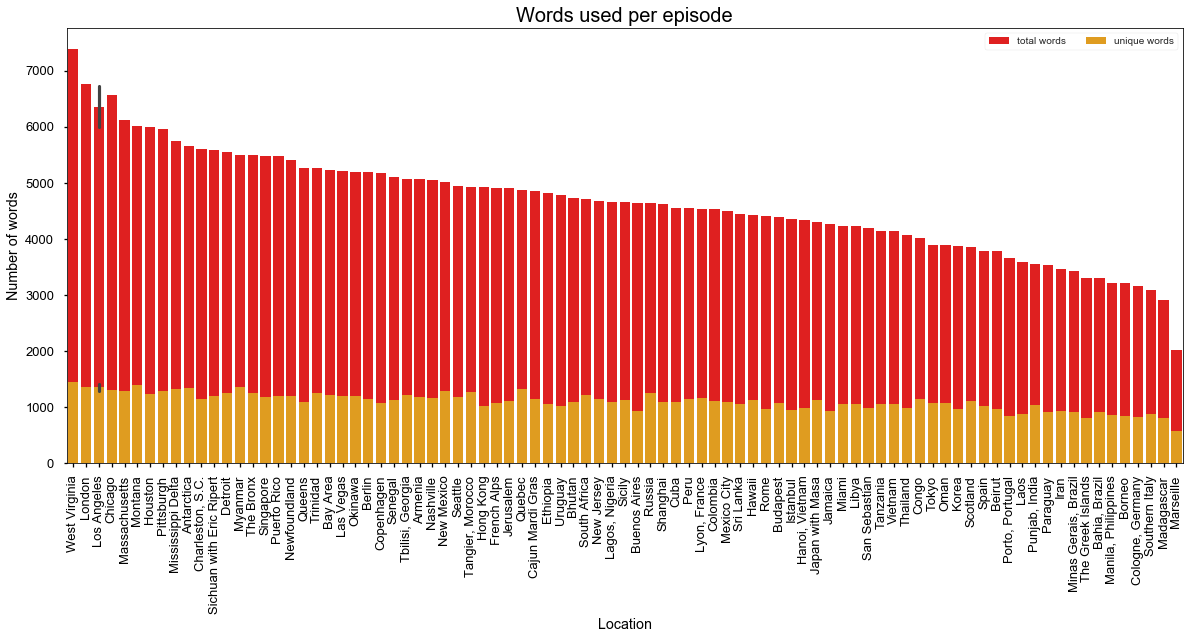

In [21]:
import seaborn as sns

sns.set_context(context='talk', font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.set(style="whitegrid")
                      
#plot total words per episode
sns.barplot(x="episode_location", y="vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="red",
            label='total words')

#plot unique words per episode
sns.barplot(x="episode_location", y="unique_vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="orange",
            label='unique words')

plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(ncol=2, loc="upper right", frameon=True)
plt.title('Words used per episode', fontsize=20)
plt.ylabel('Number of words')
plt.xlabel('Location')

plt.show()

## Identifying and Removing Stopwords

The `nltk stopwords` list of stop words isn't very comprehensive, so I wanted to generate a more detailed list of commonly used words. I made a function to return a data frame containing the tokens that occur above a certain threshold across the entire corpus. As an approximation, I defined 'common words' as tokens that occur in the corpus more than 960 times (average of 10 times per episode X 88 episodes). I added these words to the default `nltk stopwords` to create a corpus specific stopword list (`puk_stopwords`). I also removed words that were 2 or less characters in length. 

In [108]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_common_words(vocab_count_list, num_occurances):
    word_counts = []
    for word in global_vocab:
        word_counts.append((word, len(vocab_count_list[word])))
    word_counts_df = pd.DataFrame.from_records(word_counts)
    word_counts_df.columns = ['word', 'number occurances']
    words_with_num_occurances = word_counts_df[word_counts_df['number occurances'] >= num_occurances]
    return(words_with_num_occurances)

In [156]:
common_words = list((id_common_words(global_vocab, 880)).word)
print("There are {} words that occur an average of 10 or more times per episode.".format(len(common_words)))

There are 74 words that occur an average of 10 or more times per episode.


In [157]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_short_words(vocab_count_list, word_len):
    short_words = []
    for word in global_vocab:
        if len(word) <= word_len:
            short_words.append(word)
    return(short_words)

In [158]:
short_words = id_short_words(global_vocab, 2)
print("There are {} words that are 2 or fewer characters long.".format(len(short_words)))

There are 275 words that are 2 or fewer characters long.


In [159]:
from nltk.corpus import stopwords

# corpus specific stopwords

puk_stopwords = list(stopwords.words('english')) + common_words + short_words

In [160]:
# create list of words with and without stop words

all_vocab = list(global_vocab.keys())
vocab_std_stopwords = [w for w in all_vocab if w not in list(stopwords.words('english'))]
vocab_puk_stopwords = [w for w in all_vocab if w not in puk_stopwords]

print("The Parts Unknown 'corpus' contains {} words".format(len(all_vocab))) 
print("The Parts Unknown 'corpus' contains {} words not contained in standard stopwords".format(len(vocab_std_stopwords)))
print("The Parts Unknown 'corpus' contains {} words not contained in the corpus specific stopwords".format(len(vocab_puk_stopwords)))

The Parts Unknown 'corpus' contains 14057 words
The Parts Unknown 'corpus' contains 13933 words not contained in standard stopwords
The Parts Unknown 'corpus' contains 13675 words not contained in the corpus specific stopwords


## Exploring Episodes by Vocabulary

Before I dug into more rigorous corpus-wide analysis, I wanted to explore the words used in a few of my favorite episodes. To do this I calculated term frequency–inverse document frequency (TF-IDF), a measure of word importance in a particular document relative to all the documents in that corpus. Below is function that manually calculates TF-IDF and represents word frequencies in a word cloud.

In [177]:
# Libraries
from wordcloud import WordCloud

In [263]:
# return wordcloud based on words common in episode but uncommon across corpus (tf-idf)

def tfidf_wordcloud(location, doc_vocab, corpus_vocab, corpus):    
    episodeID = corpus[corpus.episode_location == location].values[0][0]
    episode_tfidf = {}
    # compute tf-idf and save to dict 
    for token in doc_vocab[episodeID]:
        if not token in episode_tfidf:
            tf = np.log(1.*doc_vocab[episodeID].count(token)) + 1.
            idf = np.log(1. + len(corpus)*1. / len(set(corpus_vocab[token])) )
            episode_tfidf[token] = tf * idf
    wordcloud.generate_from_frequencies(frequencies=episode_tfidf)
    return(wordcloud)

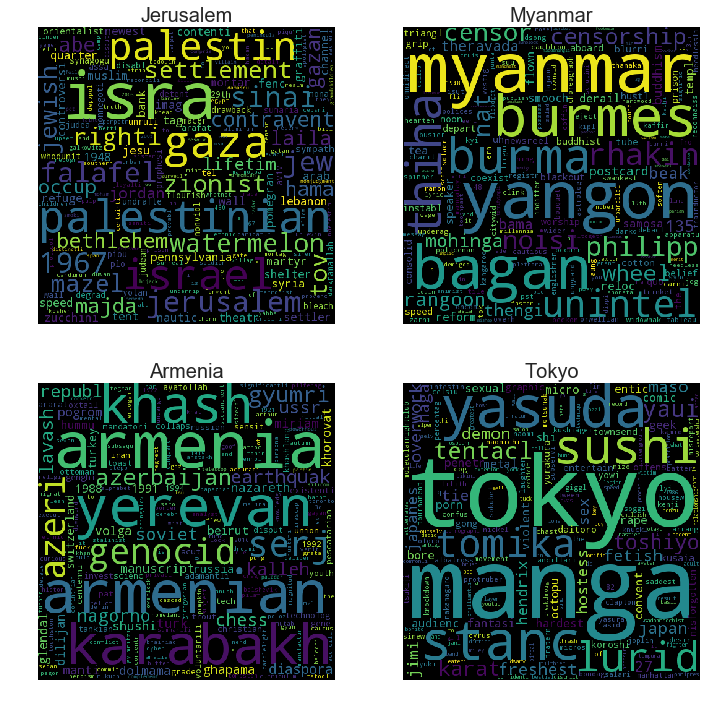

In [493]:
# create a grid plot of some interesting locations

fig = plt.figure(figsize=(12,12))
places = ['Jerusalem', 'Myanmar', 'Armenia', 'Tokyo']
for i in range(len(places)):
    ax = fig.add_subplot(2,2,i+1)
    wordcloud = tfidf_wordcloud(places[i], r_vocab, global_vocab, puk)
    plt.title('{}'.format(places[i]), size=20)
    ax.imshow(wordcloud)
    ax.axis('off')

In [494]:
episode_tfidf.keys()

dict_keys(['for', 'korean', 'american', 'accord', 'to', 'the', 'stereotyp', 'anyway', 'it', 'use', 'be', 'that', 'you', 'grew', 'up', 'a', 'doctor', 'lawyer', 'an', 'engin', 'there', 'were', 'specif', 'set', 'of', 'rule', 'and', 'expect', 'are', 'ask', 'me', 'in', 'porno', 'is', 'what', 're', 'thank', 'some', 'remark', 'bad', 'though', 'thing', 'begin', 'chang', 'i', 'went', 'one', 'year', 'law', 'school', 'walk', 'out', 'so', 'yeah', 'm', 'ani', 'final', 'advic', 'somebodi', 'who', 's', 'actual', 'about', 'marri', 'woman', 'don', 't', 'do', 'all', 'knew', 'wa', 'thi', 'town', 'go', 'down', 'no', 'show', 'we', 'as', 'figur', 'realli', 'quickli', 'point', 'where', 'look', 'at', 'each', 'other', 'say', 'they', 'not', 'come', 'toni', 'know', 'like', 'right', 'chopper', 'will', 'here', 'anytim', 'soon', 'mean', 'when', 'stuff', 'start', 'roy', 'choi', 'second', 'gener', 'he', 'live', 'lo', 'angel', 'owner', 'oper', 'four', 'groundbreak', 'much', 'love', 'food', 'truck', 'among', 'first', '

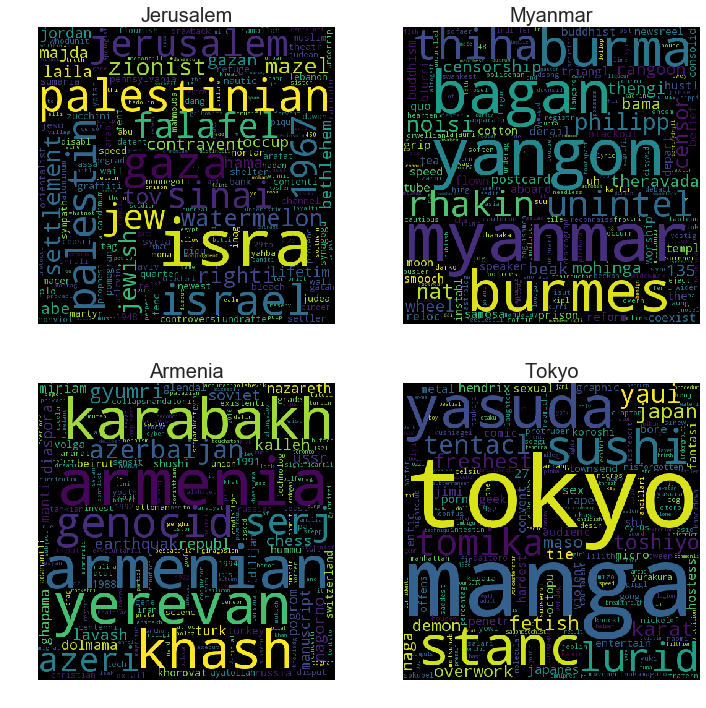

In [489]:
# create a grid plot of some interesting locations

fig = plt.figure(figsize=(12,12))
places = ['Jerusalem', 'Myanmar', 'Armenia', 'Tokyo']
for i in range(len(places)):
    ax = fig.add_subplot(2,2,i+1)
    wordcloud = tfidf_wordcloud(places[i], r_vocab, global_vocab, puk)
    plt.title('{}'.format(places[i]), size=20)
    ax.imshow(wordcloud)
    ax.axis('off')

It was striking to see how much of these essence of these places was captured simply by performing TF-IDF. The words 'zionist', 'hamas', and 'falafel' are over represented in the Jerusalem episode, while the words 'censorship', 'tea', and 'mohinga' (a spicy fish soup) pretty much sum up Myanmar. The Armenian episode not only captures the conflict with Azerbaijan and the devestating 1992 earthquake, but touches on the country's obsession with chess. Japan, it seems, is mostly about 'porn', 'sushi', 'fetishes', and 'overwork'. 

## Some tests with cosine similarity

Examining an individual episode for important words isn’t that interesting, and I wanted to identify vocabulary similarities across episodes. One would expect, for example, that geographically or culturally related places like Southern Italy and Rome might contain a significant proportion of the same words.

To address these types of questions I vectorized the data using `sklearn TfidfVectorizer`. The ` TfidfVectorizer ` converts a collection of documents to a matrix of TF-IDF features. From the transformed tfidf vector I calculated a cosine similarity matrix to measure vocabulary similarities between the episodes. Cosine similarity is a measure of the cosine of the angle between two non-zero vectors and is thus a measure of similarity. Identical vectors will have an angle of 0° and a cosine similarity score of cosine(0°) = 1. In practice, cosine similarity is often represented as distance = 1- cosine_similarity, thus identical vectors would have a distance of 1. I calculated the distance measure from the cosine similarity matrix and plotted the result on a heatmap.

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [267]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)
episode_names = list(puk.episode_location)

# I need to address the fact that there are two LA episodes
episode_names[9] = 'Los Angeles_1'
episode_names[40] = 'Los Angeles_2'

In [268]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=True,
                                   max_features=10000,
                                   max_df=60)

tfidf = tfidf_vectorizer.fit_transform(data)

In [269]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf)

In [270]:
# make df with similarity scores mapped to episodes 

cosine_sim = pd.DataFrame(dist, episode_names)
cosine_sim.columns = episode_names

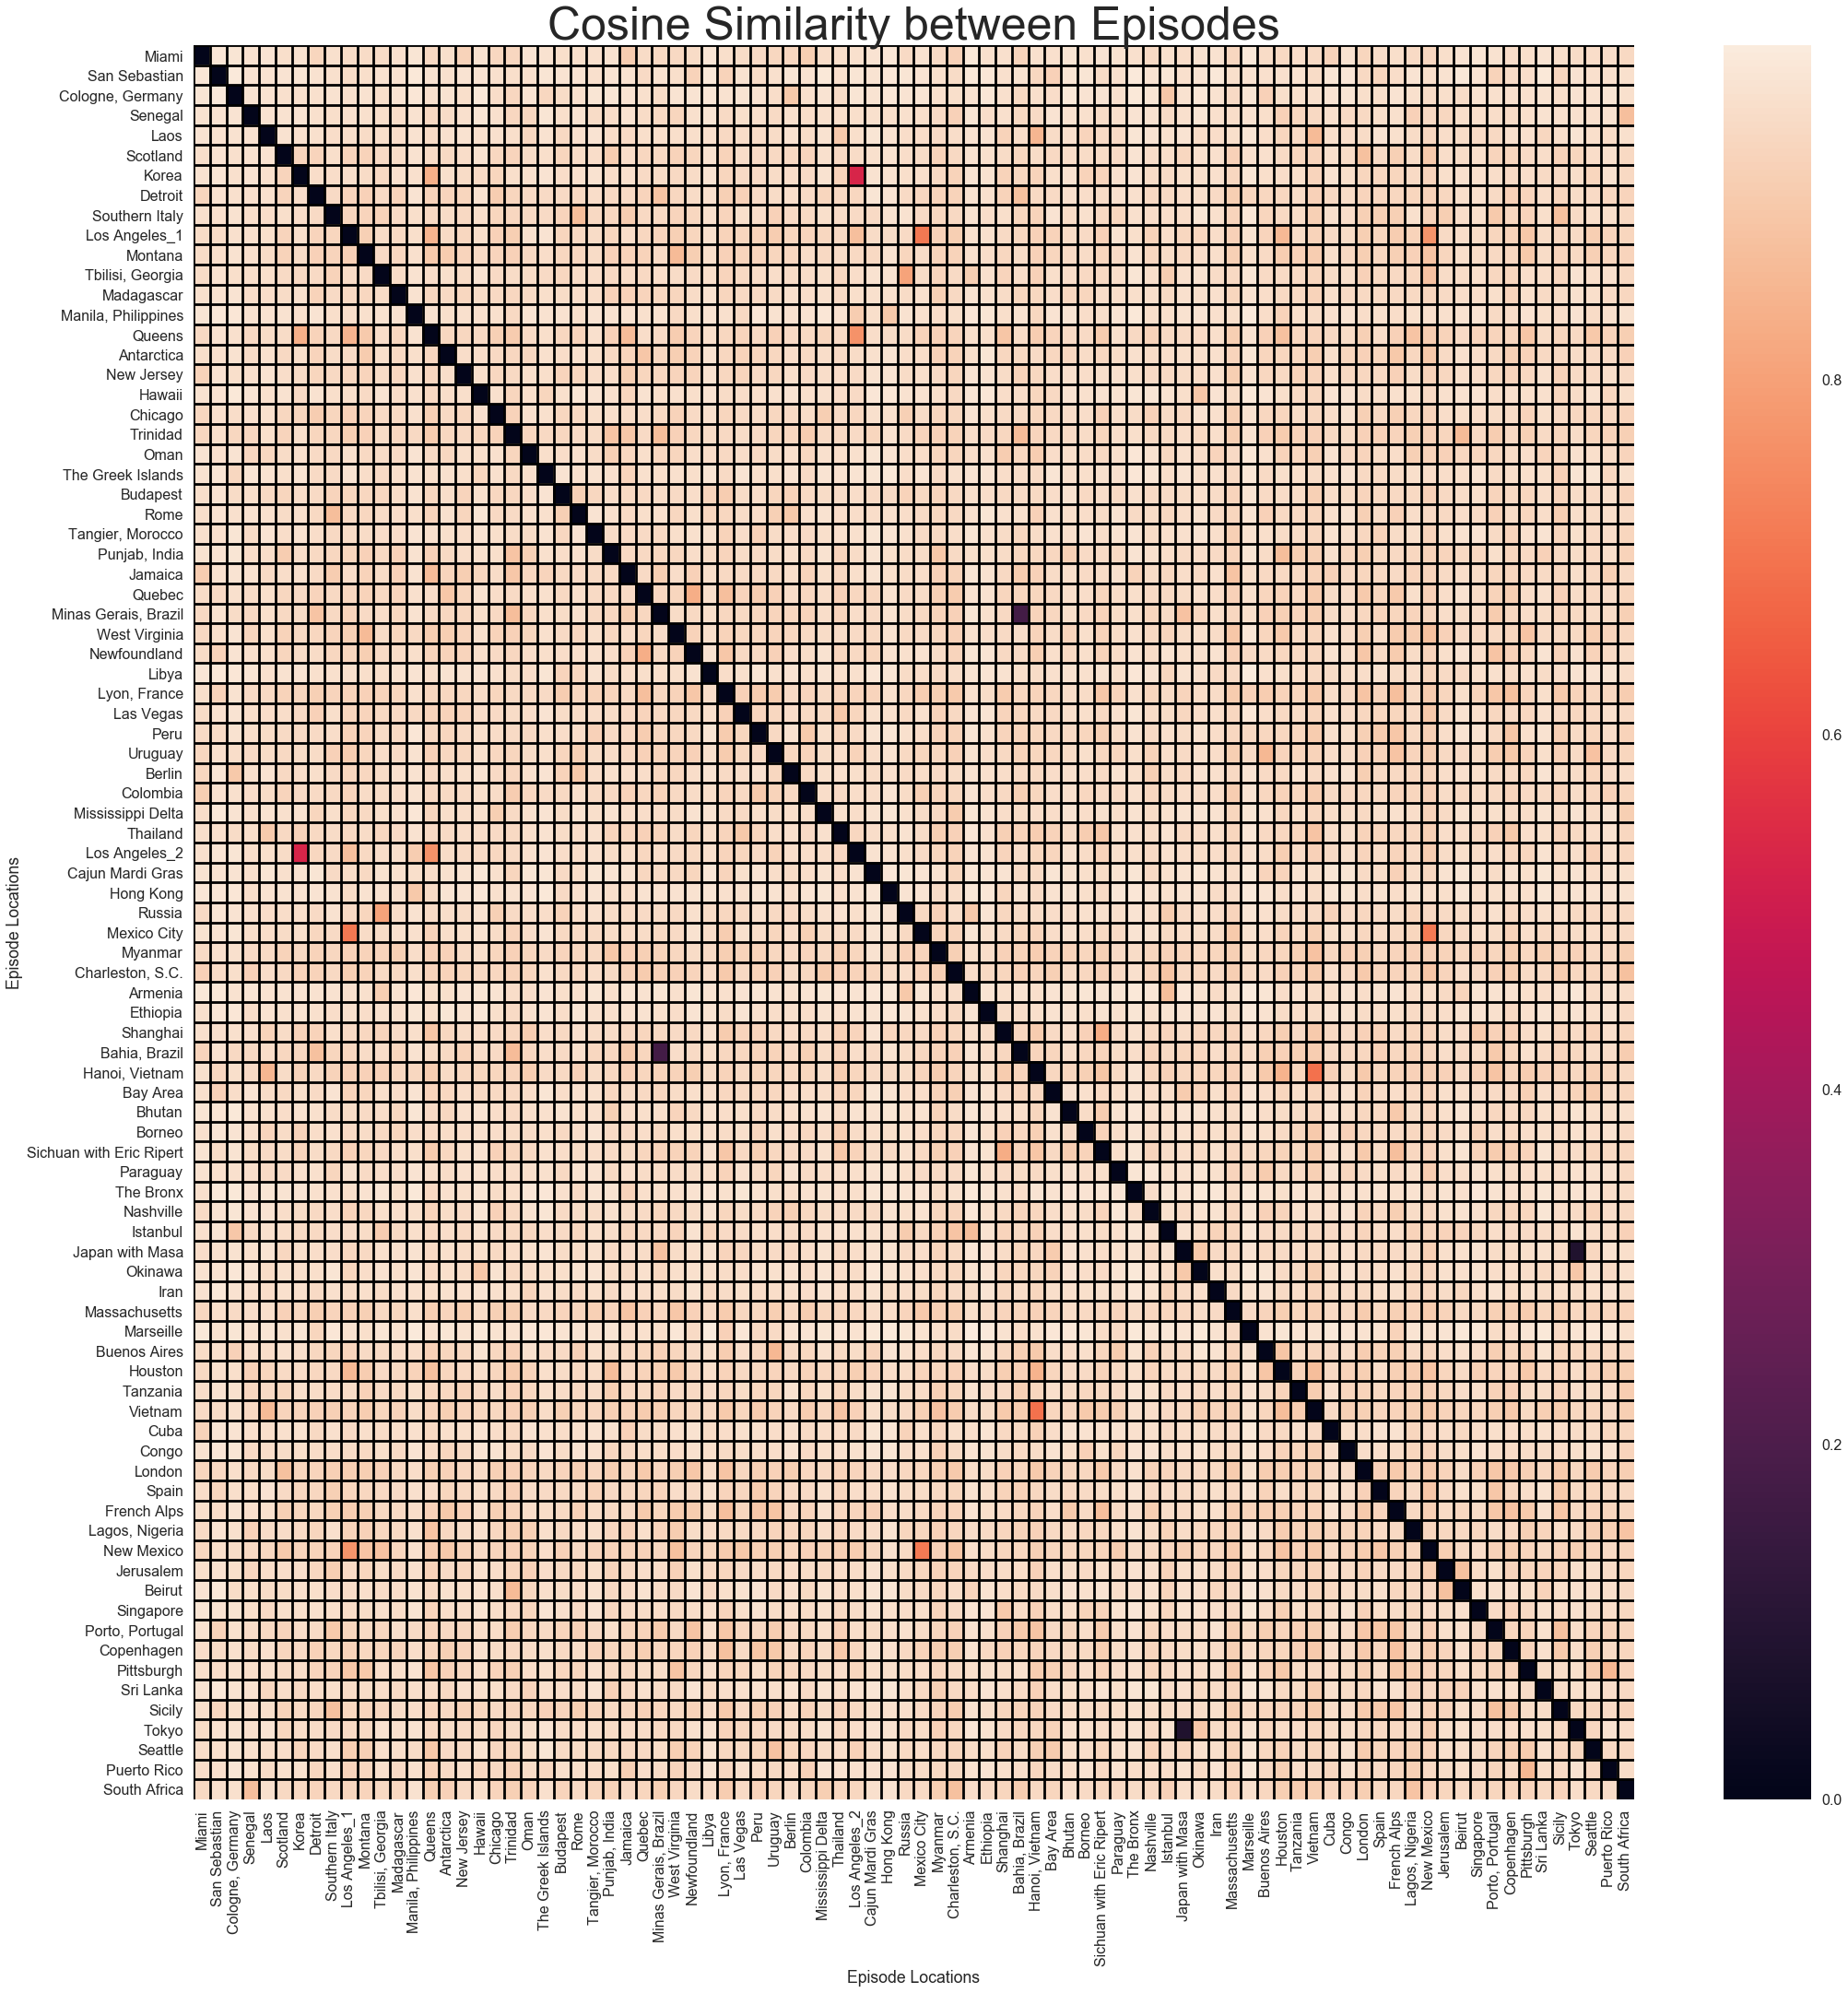

In [272]:
# Draw a heatmap with the numeric values in each cell

sns.set_context(context='poster', font_scale=1)

plt.subplots(figsize=(35,35))
ax = sns.heatmap(cosine_sim)
ax.hlines([range(len(cosine_sim))], *ax.get_xlim())
ax.vlines([range(len(cosine_sim))], *ax.get_ylim())
ax.set_xlabel('Episode Locations')
ax.set_ylabel('Episode Locations')
plt.title('Cosine Similarity between Episodes', size=50)
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

The first thing that stands out with this heatmap are the 4 strong purple points (dark purple represents a small distance between the episodes and thus higher similarity). Bourdain actually did two *Parts Unknown* episodes in Japan as well as two in Brazil, and not surprisingly these episodes use similar language. A number of other 'warm' spots were identified, and it's interesting to think about why Korea, LA, and Queens were identified as similar. 

To identify more unexpected connections between location, I mapped the 3 most similar locations for each location using the cosine similarity score. While some of these associations didn't make sense, a surprising number of reasonable geographic and cultural/political relationships were identified.

For example, 'Southern Italy' was found to be related to Sicily (a region of Southern Italy), Rome (an Italian city), and Porto, Portugal (a southern European city). Regionally, these relationships make sense. 

Similarly, Russia was found to be most similar to Georgia, Armenia, and Istanbul. Russia, Georgia, and Armenia are all part of the former USSR, and Istanbul, Turkey is both geographically proximal and has an interconnected history with Armenia (which it borders) and Russia (a sometimes ally).

The Cuba episode was most similar to episodes located in Jamaica, Miami, and Hanoi, Vietnam. Cuba is geographically and culturally related to Jamaica and Miami, but the relationship with Hanoi, Vietnam is political. Both Cuba and Vietnam are socialist countries that have had conflicts with the United States, and Hanoi is the still the seat of the socialist party in Vietnam.

Below is a selection of interesting 'most related' locations.

In [275]:
# create a list of the 3 most similar locations for each location
list_similar = []

for column in cosine_sim:
    most_similar = cosine_sim.nsmallest(4, column).index
    similar = (most_similar[0], most_similar[1], most_similar[2], most_similar[3])
    list_similar.append(similar)

In [276]:
list_similar_df = pd.DataFrame.from_records(list_similar, columns=['location', 
                                                                   'similar_1',
                                                                   'similar_2', 
                                                                   'similar_3'])

In [277]:
print('Examples of Most similar locations based on cosine similarity of episode text:')
print(list_similar_df[list_similar_df.location == 'Korea'].values)
print(list_similar_df[list_similar_df.location == 'Detroit'].values)
print(list_similar_df[list_similar_df.location == 'Los Angeles_1'].values)
print(list_similar_df[list_similar_df.location == 'Russia'].values)
print(list_similar_df[list_similar_df.location == 'Okinawa'].values)
print(list_similar_df[list_similar_df.location == 'Southern Italy'].values)
print(list_similar_df[list_similar_df.location == 'Laos'].values)
print(list_similar_df[list_similar_df.location == 'Miami'].values)
print(list_similar_df[list_similar_df.location == 'Cuba'].values)
print(list_similar_df[list_similar_df.location == 'Hong Kong'].values)

Examples of Most similar locations based on cosine similarity of episode text:
[['Korea' 'Los Angeles_2' 'Queens' 'Thailand']]
[['Detroit' 'Bahia, Brazil' 'Minas Gerais, Brazil' 'Chicago']]
[['Los Angeles_1' 'Mexico City' 'New Mexico' 'Queens']]
[['Russia' 'Tbilisi, Georgia' 'Armenia' 'Istanbul']]
[['Okinawa' 'Hawaii' 'Tokyo' 'Japan with Masa']]
[['Southern Italy' 'Rome' 'Sicily' 'Porto, Portugal']]
[['Laos' 'Hanoi, Vietnam' 'Vietnam' 'Thailand']]
[['Miami' 'Jamaica' 'Colombia' 'Charleston, S.C.']]
[['Cuba' 'Hanoi, Vietnam' 'Jamaica' 'Miami']]
[['Hong Kong' 'Manila, Philippines' 'Shanghai' 'Hanoi, Vietnam']]


## Modeling Topics with Non-negative Matrix Factorization (NMF)

Now that I've identified some similiarities across the episode transcripts in the Parts Unknown corpus, I wanted to identify common themes. I used Non-negative Matrix factorization (NMF) to model themes in the episodes of *Parts Unknown*. The episode transcripts were tokenized using the `nltk.word_tokenize` tokenizer, stemmed with the `PorterStemmer()`, and saved into a dictionary with was fit to the `TfidfVectorizer`. See my GitHub repo for my exploration of different tokenizers, stemmers, and `tfidf_vectorizer` parameters.

In [463]:
# get words from vectorizer and map back to NMF model; 
# modified from https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

from sklearn.decomposition import NMF

def get_nmf_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    n_top_words = -1 * n_top_words
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Theme # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

#### Method 1. Use TfidfVectorizer with Porter Stemmer

In [464]:
# define stemmer and tokenizer and fit TfidfVectorizer

token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text.translate(translator))
    stems = stem_tokens(tokens, stemmer)
    return stems

for idx, episode in puk.iterrows():
    episode_name = episode.episodeID
    text = episode.clean_text
    lowers = text.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[episode_name] = no_punctuation
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=puk_stopwords)
tfs = tfidf.fit_transform(token_dict.values())

In [465]:
# fit NMF model to tfs
model1 = NMF(n_components=10, init='nndsvd', random_state=42)

W1 = model1.fit_transform( tfs )

In [466]:
# get topic components

get_nmf_topics(model1, tfidf, 10, 15)

,Theme # 01,Theme # 02,Theme # 03,Theme # 04,Theme # 05,Theme # 06,Theme # 07,Theme # 08,Theme # 09,Theme # 10
0,chef,sushi,brazil,korean,beirut,mexico,vietnam,place,berlin,armenian
1,eat,tokyo,salvador,korea,countri,mexican,lao,gon,cologn,russia
2,fish,manga,caipirinha,han,africa,taco,vietnames,live,rome,georgia
3,food,yasuda,brazilian,food,india,cartel,noodl,got,hong,putin
4,cook,japanes,african,seoul,see,trejo,hanoi,want,kong,russian
5,littl,japan,inaud,game,seneg,spanish,rice,lot,roman,armenia
6,well,stanc,bahia,rockaway,congo,gun,china,work,mussolini,turkey
7,chees,inaud,detroit,queen,would,drug,back,town,german,georgian
8,okay,karat,capoeira,drink,war,topito,singapor,make,hungari,istanbul
9,make,tentacl,cachaca,roy,mani,mescal,hue,would,film,soviet


In [288]:
# save topics to df with labels

topic1_names = ['foodie', 'japanese_weirdness', 'brazil_african', 'korea', 'conflict_places','sw_tacos', 
                'se_asia', 'random', 'euro_cities(ish)', 'ussr&friends']

topics1 = get_nmf_topics(model1, tfidf, 10, 15)
topics1.columns = topic1_names

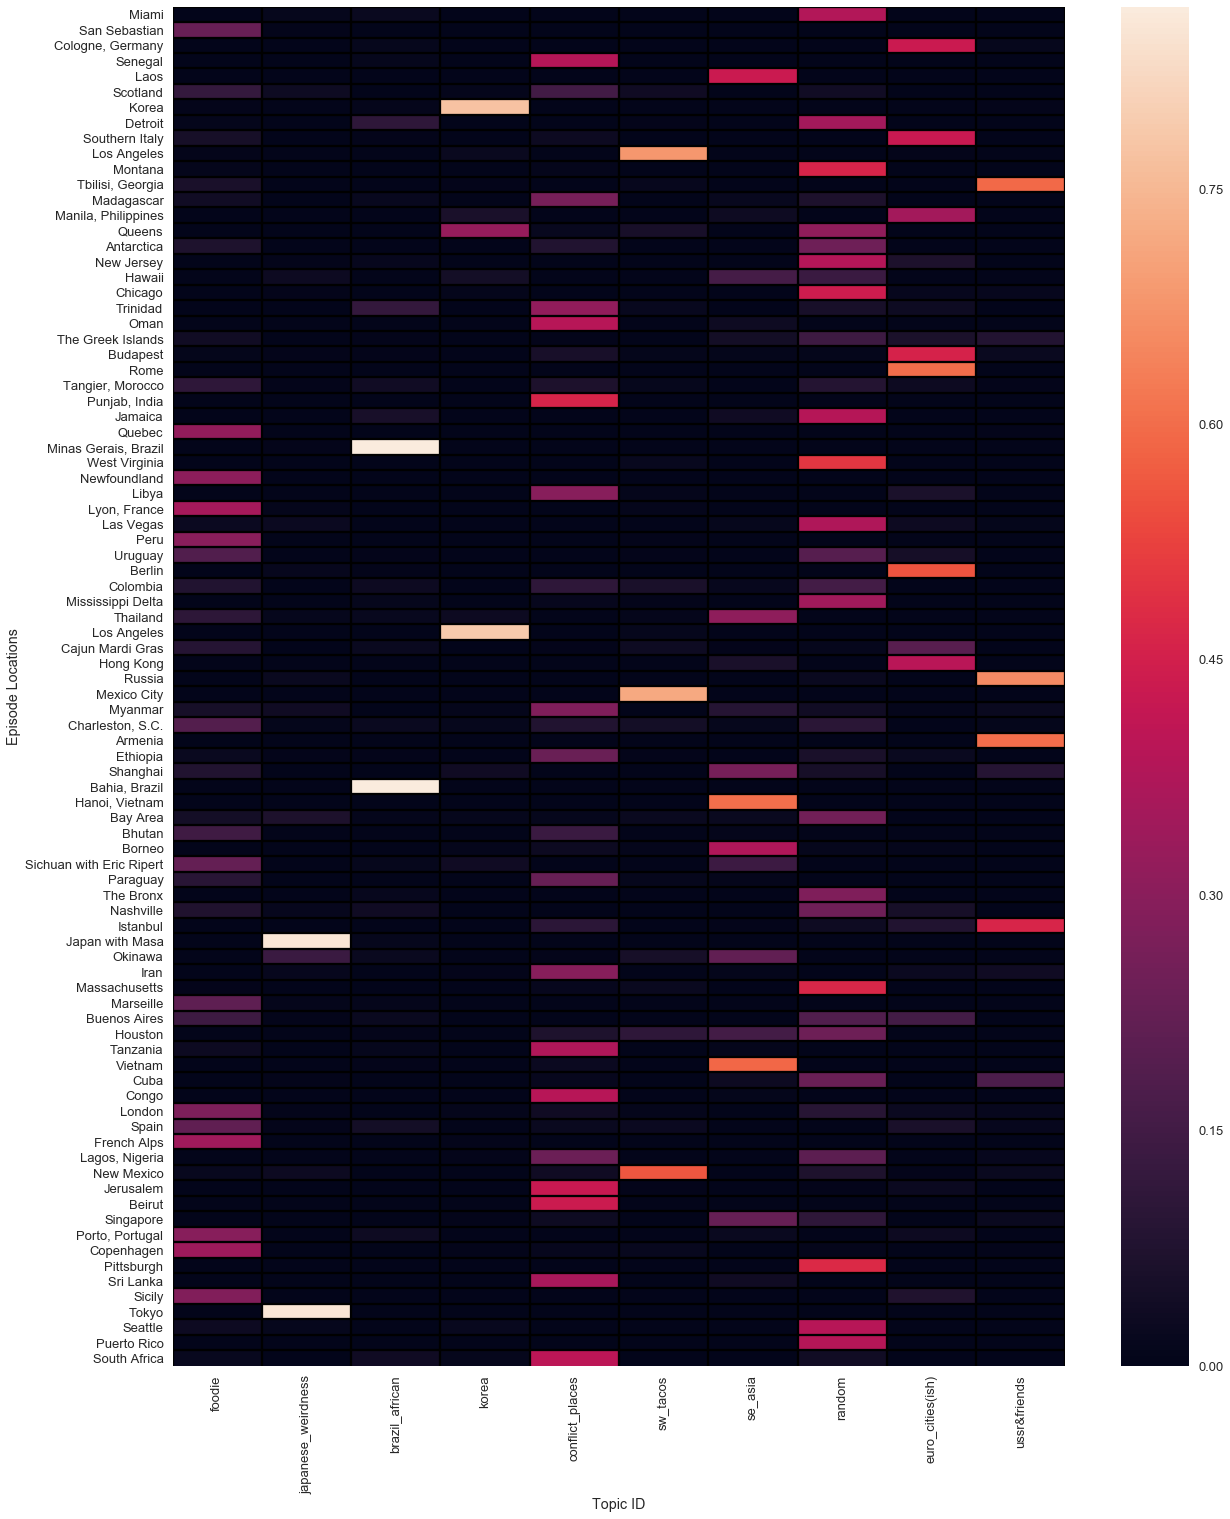

In [289]:
# set up df of episode scores by topics

episode_locations = puk.episode_location
episode1_scores = pd.DataFrame(W1,index=episode_locations)
episode1_scores.columns = topic1_names

import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode1_scores)
ax.hlines([range(len(episode1_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Topic ID')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

#### Method 2. Use TfidfVectorizer without stemming

In [291]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)

In [292]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=False,
                                   max_features=10000,
                                   max_df=60)

tfidf = tfidf_vectorizer.fit_transform(data)

In [298]:
# fit NMF model
model = NMF(n_components=10, init='nndsvd', random_state=42)

W = model.fit_transform( tfidf )
H = model.components_

In [299]:
# get top 20 topics 

get_nmf_topics(model, tfidf_vectorizer, 10, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,newfoundland,tokyo,brazil,korean,vietnam,mexico,china,gonna,africa,russia
1,lyon,sushi,salvador,koreans,vietnamese,mexican,singapore,berlin,beirut,georgia
2,chocolate,manga,caipirinha,korea,hanoi,trejo,chinese,nashville,india,putin
3,cheese,yasuda,brazilian,han,lao,spanish,éric,puerto,trinidad,armenian
4,basque,japanese,bahia,queens,hue,topito,hong,pittsburgh,congo,armenia
5,chef,stance,inaudible,seoul,war,gun,shanghai,coal,senegal,istanbul
6,sicily,japan,detroit,koreatown,laos,tacos,sichuan,chicago,miami,turkey
7,wine,inaudible,pellorinio,sizzler,squid,morrissey,kong,rome,war,russian
8,marseille,tentacle,african,roy,houston,santa,thailand,music,jamaica,soviet
9,france,karate,cachaca,kimchi,rice,nate,noodles,braddock,south,georgian


In [303]:
# save topics to df with labels

topic_names = ['random', 'japanese_weirdness', 'brazil_african', 'korea', 'se_asia','sw_tacos', 
                'chinese_influence', 'random2', 'conflict_places', 'ussr&friends']

topics = get_nmf_topics(model, tfidf_vectorizer, 10, 15)
topics.columns = topic_names

In [304]:
# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W,index=episode_locations)
episode_scores.columns = topic_names

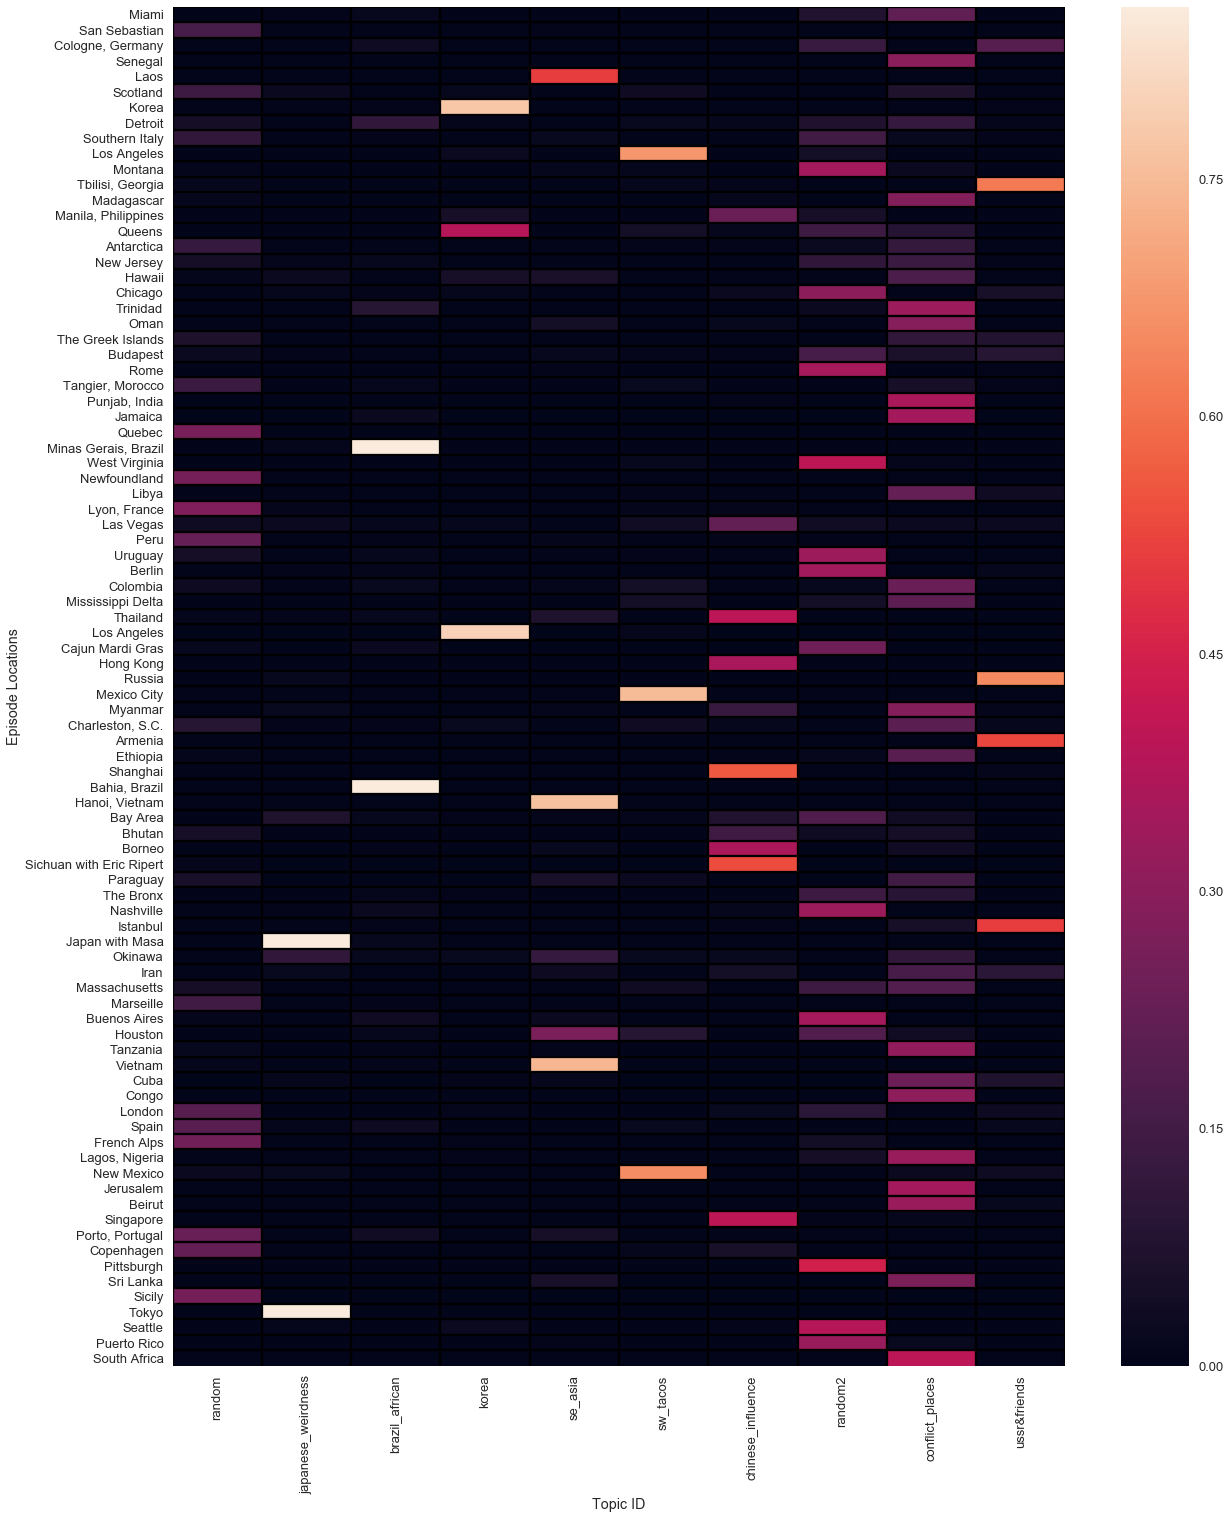

In [305]:
import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Topic ID')
ax.set_ylabel('Episode Locations')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

In [65]:
print('The sum of topic scores for the non-stemmed NMF model:')
episode_scores.sum().sort_values(ascending=False)

The sum of topic scores for the non-stemmed NMF model:


ex_colonies            3.365698
island_influence       3.110459
africa_race            3.090173
random2                2.857565
southern_euro          2.730920
no_idea                2.609028
usa                    2.562083
cartel_tacos           2.510236
loosely_french(ish)    2.426212
chinese_sphere         2.423237
troubled_placed        2.352743
brazil_african         2.126498
japanese_weirdness     2.069501
immigrants_germany     2.025482
se_asian_treats        2.012167
korea                  1.987261
random_3               1.562925
interzone              1.340787
random                 1.245621
ussr&pals              1.228523
dtype: float64

In [66]:
print('The sum of topic scores for the stemmed NMF model:')
episode1_scores.sum().sort_values(ascending=False)

The sum of topic scores for the stemmed NMF model:


generic_euro_french    4.771249
party_place            3.723846
troubled_regions       3.548582
ex_colonies            3.356614
africa_influence       3.297192
se_asia                2.915091
random                 2.838377
southern_euro          2.771510
brazil_african         2.335171
sw_tacos               2.277015
japanese_weirdness     2.124580
korea                  2.124071
island                 1.839882
random_asian           1.785251
immigrants_germany     1.719037
random                 1.705652
random                 1.587691
ussr&pals              1.445062
random3                1.436865
NYC                    1.427622
dtype: float64

### Method 3. No Stemming and allowance of n-grams (n=1-3)

In [468]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, 
                                   stop_words=puk_stopwords,
                                   smooth_idf=False,
                                   max_features=10000,
                                   max_df=60,
                                   ngram_range=(1,3))

tfs = tfidf_vectorizer.fit_transform(token_dict.values())

# fit NMF model
model = NMF(n_components=10, init='nndsvd', random_state=42)

W = model.fit_transform( tfs )
H = model.components_

# get top 10 topics 
print('High TF-IDF Score Words by Theme:')
get_nmf_topics(model, tfidf_vectorizer, 10, 15)

High TF-IDF Score Words by Theme:


,Theme # 01,Theme # 02,Theme # 03,Theme # 04,Theme # 05,Theme # 06,Theme # 07,Theme # 08,Theme # 09,Theme # 10
0,chef,tokyo,brazil,korean,beirut,mexico,vietnam,berlin,miami,armenian
1,newfoundland,sushi,salvador,korea,africa,mexican,lao,rome,gon,russia
2,lyon,manga,caipirinha,han,india,new mexico,vietnames,itali,detroit,georgia
3,chocol,yasuda,brazilian,seoul,seneg,taco,noodl,bueno air,mississippi,putin
4,basqu,japanes,african,rockaway,congo,cartel,hanoi,cologn,puerto,armenia
5,chees,stanc,bahia,queen,oman,trejo,china,uruguay,bronx,russian
6,marseil,japan,inaud,game,trinidad,spanish,hue,bueno,beach,istanbul
7,quebec,inaud,world cup,sizzler,gaza,gun,rice,roman,chicago,turkey
8,eric,karat,pellorinio,koreatown,african,mescal,singapor,music,island,georgian
9,truffl,tentacl,capoeira,kimchi,palestinian,topito,thailand,mussolini,pittsburgh,soviet


The collection of words in 'Theme 1' didn't make sense to me initially, but I explored the episodes with high 'Theme 1' scores and noticed that these were destinations that Bourdain visited with other chefs. The episodes filmed in Sichuan, Peru, Marseille, and the French Alps were filmed with his friend Eric Ripert; the Newfoundland and Quebec episodes feature the chef duo Dave McMillan and Fred Morin; and the episodes filmed in Copenhagen (with chef Alessandro Porcelli), Lyon (with Daniel Boulud), San Sebastian (with Juan Mari and Elena Arzak), and London (various chefs) all feature food and food preparation prominently. Food words like 'truffle', 'wine', and 'chocolate' occur regularly, so I termed this theme `'foodie'`.

Themes 2 (`'japanese_weirdness'`), 3 (`'brazil_african'`), and 4 (`'korea'`) are clearly related to Japan, Brazil, and Korea respectively. 

Theme 5 (`'conflict_places'`) appears to be related to places of heightened conflict, like Beirut, Sri Lanka, and several African countries. 

Theme 6 (`'sw_tacos'`) represents Spanish-Mexican culture and is spread over many locations, including LA, Mexico City, Spain, Colombia, Houston, New Mexico. 

Theme 7 (`'se_asia'`) represents Asian food, particularly South East Asian foods, a Bourdain favorite. 

Theme 8 (`'random'`) has no discernable theme to me. 

Theme 9 (`'america'`) is loosely American. 

Finally, Theme 10 (`ussr&friends`) represents countries that were in the former USSR (Russia, Georgia, and Armenia) as well as culturally and geographically related neighbors (like Turkey).

Below is a heatmap of how each location scores for each identified theme.

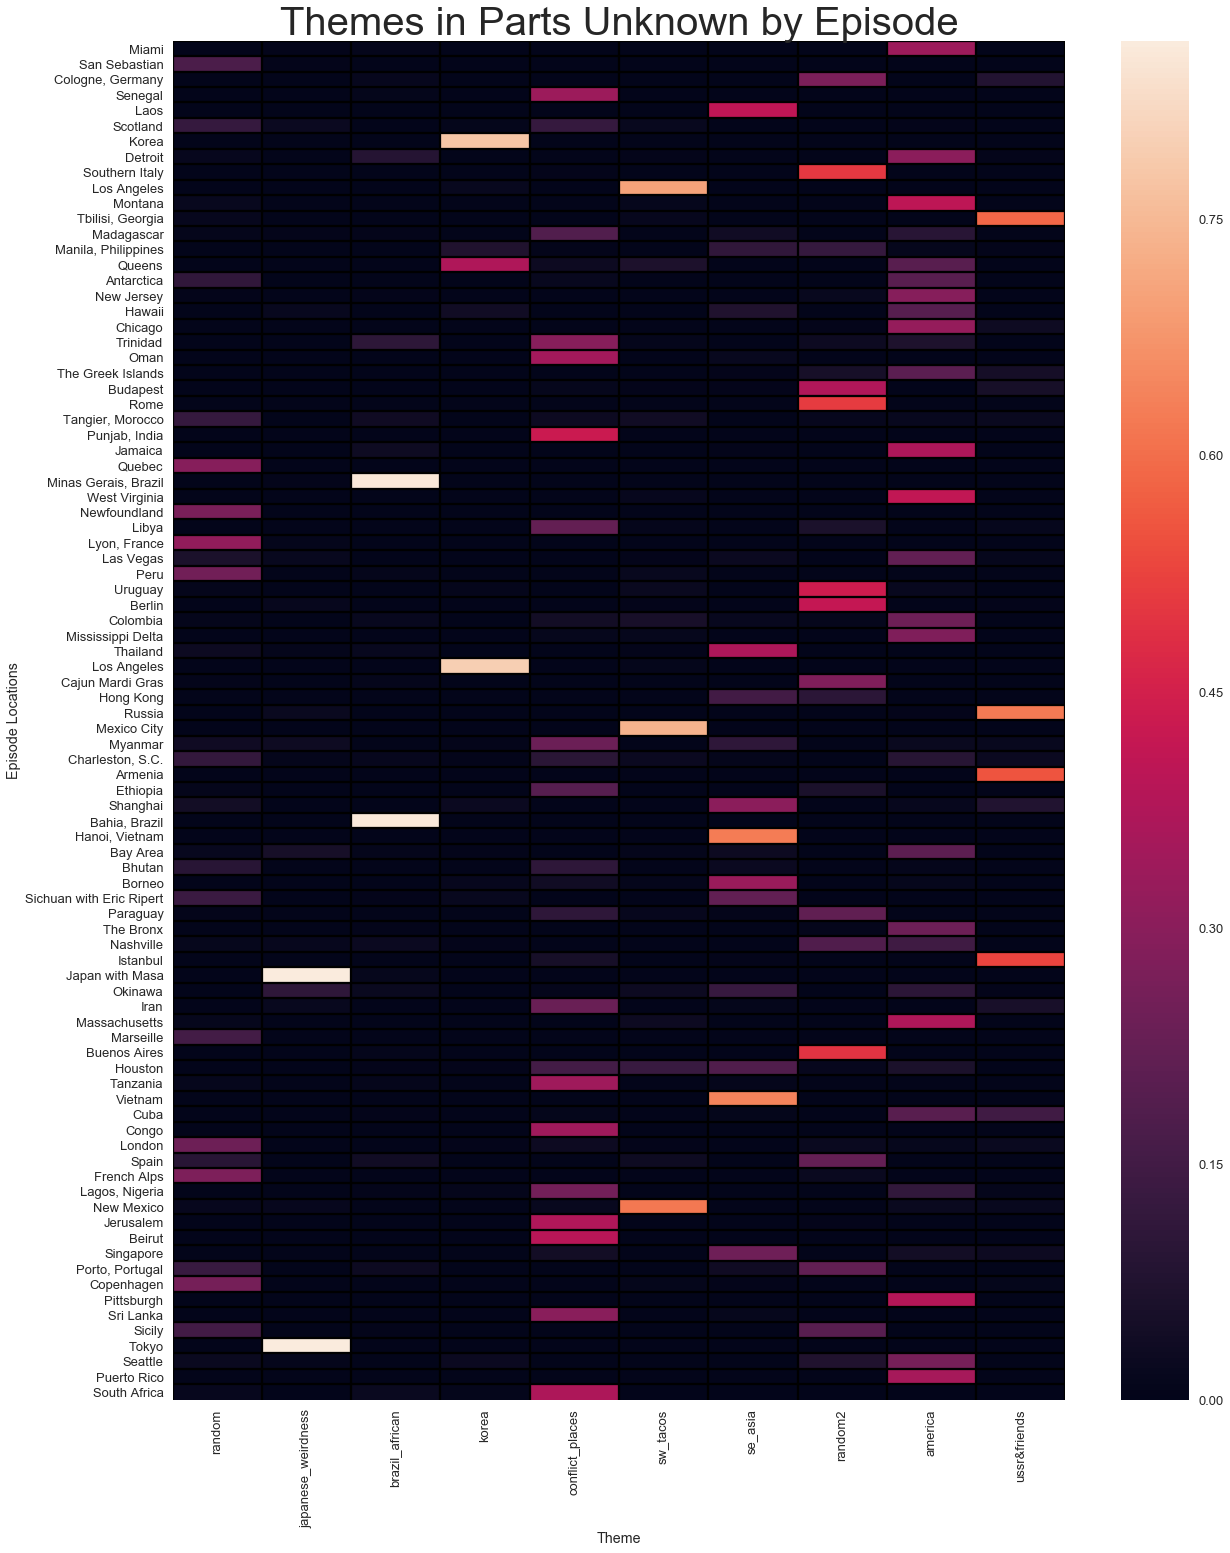

In [321]:
# save topics to df with labels

topic_names = ['foodie', 'japanese_weirdness', 'brazil_african', 'korea', 'conflict_places','sw_tacos', 
                'se_asia', 'random', 'america', 'ussr&friends']

topics = get_nmf_topics(model, tfidf_vectorizer, 10, 15)
topics.columns = topic_names

# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W,index=episode_locations)
episode_scores.columns = topic_names

import matplotlib.pyplot as plt

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Theme')
ax.set_ylabel('Episode Locations')
plt.title('Themes in Parts Unknown by Episode', size=40)
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

## Refining the NMF model

I noticed that lots of the 'top words' in the topics were proper nouns like places, languages, and ethnicities. To identify topics more broadly, I added countries, cities, regions, continents, languages, and names to my list of stopwords.

In [309]:
# read in csv with episode location information
place_names = pd.DataFrame.from_csv('supplemental_data/world-cities.csv',  index_col=None)

In [310]:
# list of countries

countries = list(place_names.country.unique())
countries = [i.lower() for i in countries]

In [311]:
# list of cities

cities = list(place_names.name.unique())
cities = [i.lower() for i in cities]

In [312]:
# list of subcountry (this includes some cities)
import six
subcountry = list(place_names.subcountry.unique())
subcountry = [i.lower() for i in subcountry if isinstance(i, six.string_types)]

In [313]:
# list of nationalities
nationalities = pd.DataFrame.from_csv('supplemental_data/nationalities.csv',  index_col=None)

In [314]:
nationalities_list = nationalities.columns
nationalities = [i.lower() for i in nationalities]
plural_nationalities = [i+'s' for i in nationalities]

In [315]:
continents = ['asia', 'africa', 'north' 'america', 'south', 'antarctica', 'europe', 'australia']
plural_continents = ['asian', 'african', 'north' 'american', 'south', 'antarctican', 'european', 'australian']

In [316]:
exceptions = ['bogota', 'korea', 'korean', 'koreans','istanbul', 'lao', 'hawaiian', 'naxos', 'okinawan', 'bronx',
             'romans', 'vegas', 'cologne', 'glasgow', 'congo', 'puerto', 'rico', 'sri', 'lanka', 'lankan', 'britt', 
             'gonna', 'okinawans', 'atlantic', 'palestinian', 'buenos', 'aires', 'éric', 'eric', 'andy', '000',
             'queens', 'francisco', 'sicilian', 'newfoundland', 'chiang mai', 'chiang', 'mai', 'zamir', 'ricans',
             'braddock', 'blackwell', 'serj', 'jiu', 'jitsu', 'pelourinho', 'hue', 'hong', 'kong', 'antonio', 'port',
             'fred', 'conrad', 'john', 'bourdain', 'lynch']

In [318]:
puk_stopwords_expanded = (puk_stopwords + countries + cities + subcountry + 
                           nationalities + plural_nationalities + continents + 
                           plural_continents + exceptions)

In [324]:
# generate new tf-idf vector using expanded stopword list

tfidf = TfidfVectorizer(stop_words=set(puk_stopwords_expanded),
                        smooth_idf=False,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfs = tfidf.fit_transform(token_dict.values())

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

# get topic components

get_nmf_topics(model_themes, tfidf, 10, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,war,sushi,caipirinha,chocolate,music,coal,island,noodles,mussolini,carnival
1,putin,yasuda,inaudible,cheese,white,gun,beach,rice,gypsy,mardi
2,soviet,stance,world cup,chef,community,mining,islands,drink,marcus,mardi gras
3,political,inaudible,pellorinio,wine,neighborhood,stream,yamas,beer,maya,kolsch
4,government,tentacle,capoeira,basque,street,mines,bond,pork,music,gras
5,hezbollah,karate,cachaca,bread,black,desert,caribbean,drinking,film,beer
6,religious,sex,instruments,farm,hip hop,ice,rum,spicy,vilmos,tango
7,optimistic,lurid,blowfish,moose,hop,mcmurdo,vieques,war,ostia,christmas
8,revolution,want kill,music,pig,hip,masai,water,karaoke,tarantula,summer
9,sultan,bored,dende,bladder,tech,guns,ding,longhouse,war,therapy


Removing place names from the vocabulary reveals general themes across the *Parts Unknown* corpus. Two location specific themes do emerge (Theme 2 is related to `'japanese_weirdness'` and Theme 3 is strongly Brazilian (`'caribbean_afro_influence'`), as well as three seemingly random themes (Theme 6, Theme 9, and Theme 10). 

The remaining themes, however, a fairly universal and highlight the overarching themes of *Parts Unknown*.

Theme 1 (`'conflict_areas'`) includes places of religious, political, and ideological tension. Episodes that score highly for this theme are Beirut, Istanbul, Sri Lanka, Armenia, and Russia. I find it interesting that in addition to the negative words associated with this theme, 'peace' and 'hope' score highly.

Theme 4 (`'foodie'`) includes peaceful places where presumably Bourdain ate quite well. These episodes include Lyon, France, Newfoundland, Quebec, and Sicily.

Themes 5 (`'music_urban_culture'`) is a general theme of music, urban culture, gentrification, and racial issues. The 12 highest scoring episodes in this theme are American cities.

Theme 7 (`'island'`) encompasses island locations of surprising geographic diversity, with the top scoring locations being Jamaica, Hawaii, Puerto Rico, the Green Islands, and Okinawa. These places have very little in common aside from the fact that they are all islands. 

Theme 8 (`'asian_food'`) highlights Bourdain's love of Asian food, and is the only specific cuisine identified as a theme. I find it particularly satisfying that one of the top words for this category is 'mmm'. Locations scoring high for this theme are Thailand, Vietnam, Hong Kong and Singapore.

Below is a heatmap of how each location scores for each identified theme.

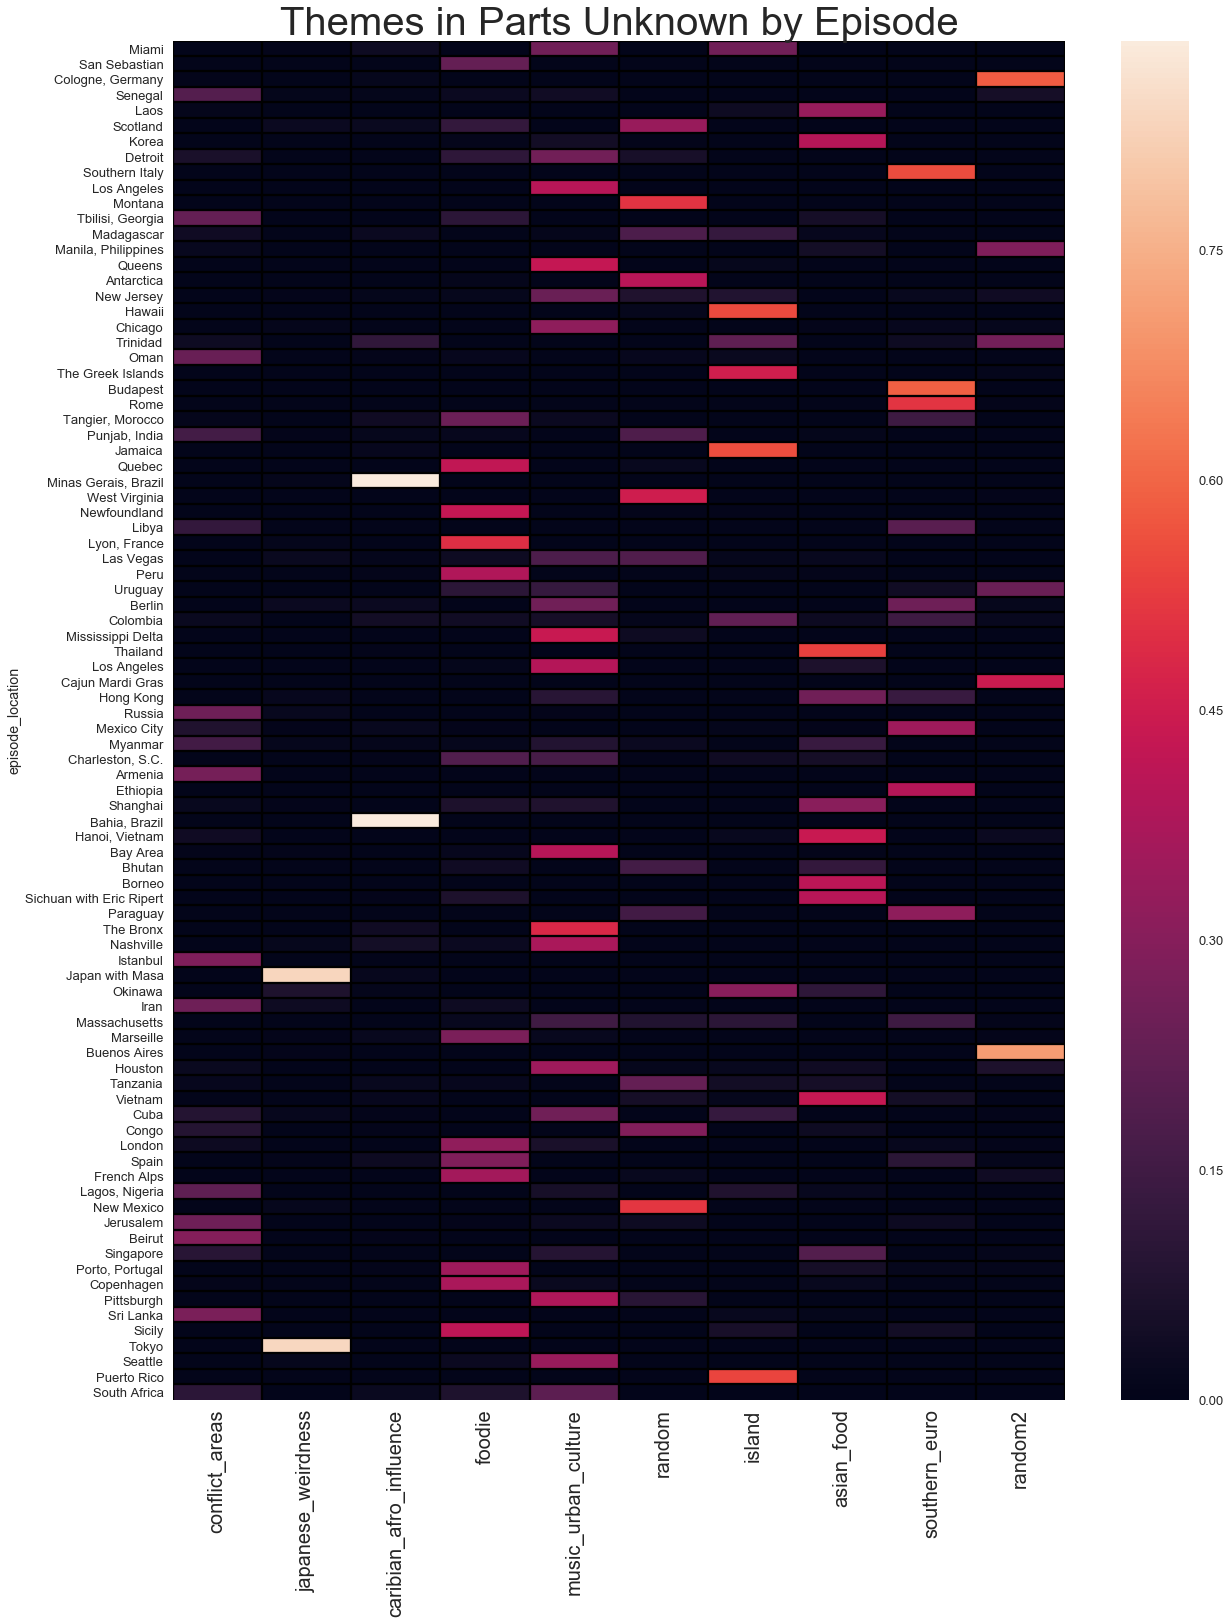

In [390]:
# save topics to df with labels

topic_names = ['conflict_areas', 'japanese_weirdness', 'caribbean_afro_influence', 'foodie', 
               'music_urban_culture', 'random', 'island', 'asian_food', 'random2', 'random3']

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

# get topic components

get_nmf_topics(model_themes, tfidf, 10, 10)

# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W_themes,index=episode_locations)
episode_scores.columns = topic_names

sns.set_context(context='talk', font_scale=1)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(20,25))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
plt.title('Themes in Parts Unknown by Episode', size=40)
plt.setp(ax.get_xticklabels(), rotation=90, size=20)

plt.show()

## Using NMF for Dimensionality Reduction and KMeans Clustering

In the exploration above, I used a value of `k=10` to build an NMF model of 10 clusters. This `k` value was selected by experimenting with a range of `k` values and manually classifying sensible topics. This is a non-rigorous approach, but there is not a clean method to identify the 'optimal' cluster number for an NMF model. To more robustly validate the number of themes in the Parts Unknown corpus, I used the `sklearn.cluster KMeans` algorithm.


Like NMF, KMeans is an unsupervised clustering algorithm that is popular for text clustering and topic identification. While NMF is a linear algebraic method represents data elements as a mixture of constituent vectors, KMeans is a quantization technique that partitions the data discretely into clusters. A KMeans model allows data elements to belong to only one cluster and the distance of each element to the associated cluster center (centroid) is a convenient way to score the model. 

The ‘elbow method’ is a commonly used approach to determine the appropriate number of clusters in a KMeans model, and entails calculating and plotting the sum of squared errors (SSE) for KMeans models over a range of `k` values. My initial elbow plot did not convergence at an elbow, meaning that the algorithm could not identify separate clusters in the raw data. A text corpus is a fairly high dimension space, and the Kmeans algorithm wasn’t dealing well with the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  

To address this issue, I used my initial NMF topic matrix as input for a KMeans model (rather than the vectorized TFIDF matrix). This approach massively reduced dimensionality since each document was represented as a mixture of 10 NMF scores rather than a collection of 10,000 TFIDF scores. Using this approach, the elbow method identified `k=9` as the best number of topics (lowest SSE, see notebook on GitHub for elbow plots). 

Examining the output of the KMeans models with and without dimensionality reduction was an enlightening exercise. Below are the identified clusters (`k=9`) for KMeans models without and with dimensionality reduction.

In [354]:
from sklearn.cluster import KMeans

In [376]:
# make tfidf from tokenized and stemmed data and fit nmf model

tfidf = TfidfVectorizer(stop_words=set(puk_stopwords_countries),
                        smooth_idf=False,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfs = tfidf.fit_transform(token_dict.values())

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

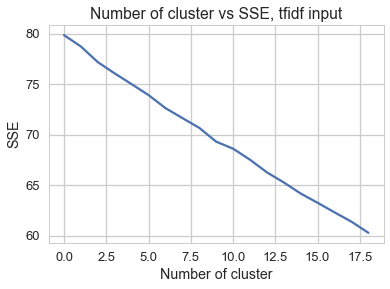

In [375]:
# elbow plots with no dimensionality reduction

num_clusters  = range(1, 20)

km = [KMeans(n_clusters=i) for i in num_clusters]

sse_test = {}

for i in range(len(km)):
    kmeans = km[i].fit(tfs)
    sse_test[i] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse_test.keys()), list(sse_test.values()))
plt.title("Number of cluster vs SSE, tfidf input")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

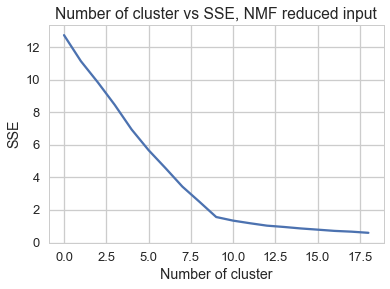

In [377]:
#  elbow plots using NMF for dimensionality reduction
num_clusters  = range(1, 20)

km = [KMeans(n_clusters=i) for i in num_clusters]

sse_test = {}

for i in range(len(km)):
    kmeans = km[i].fit(W_themes)
    sse_test[i] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse_test.keys()), list(sse_test.values()))
plt.title("Number of cluster vs SSE, NMF reduced input")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [357]:
## Using num_clusters identified in model built on matrix with NMF dimensionality reduction

num_clusters = 9

km = KMeans(n_clusters=num_clusters, random_state=42)

km.fit(W_themes)

clusters = km.labels_.tolist()

In [358]:
from sklearn.externals import joblib

# pickle model
joblib.dump(km,  'doc_cluster.pkl')

#load pickled model
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [508]:
words = pd.Series(puk_stopwords_countries)

In [509]:
words.to_csv('words.csv')

In [359]:
# dictionary and df of episode content

episodes = { 'episodeID': list(puk.episodeID), 'episode_location': list(puk.episode_location), 'date': list(puk.air_date), 'cluster': clusters}

frame = pd.DataFrame(episodes, index = [clusters] , columns = ['episodeID', 'episode_location', 'date', 'cluster'])

In [360]:
# print episodes in each cluster

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    episode_list = []
   
    for episode in frame.loc[i]['episode_location']:
        episode_list.append(episode)
    print("Cluster {} episodes, {} episodes:  ".format(i, len(episode_list)))
    print(', '.join(episode_list))

    print('') #add whitespace
    print('') #add whitespace

Cluster 0 episodes, 10 episodes:  
Laos, Korea, Thailand, Hong Kong, Shanghai, Hanoi, Vietnam, Borneo, Sichuan with Eric Ripert, Vietnam, Singapore


Cluster 1 episodes, 13 episodes:  
San Sebastian, Tangier, Morocco, Quebec, Newfoundland, Lyon, France, Peru, Marseille, London, Spain, French Alps, Porto, Portugal, Copenhagen, Sicily


Cluster 2 episodes, 20 episodes:  
Miami, Detroit, Los Angeles, Queens, New Jersey, Chicago, Las Vegas, Berlin, Mississippi Delta, Los Angeles, Charleston, S.C., Bay Area, The Bronx, Nashville, Massachusetts, Houston, Cuba, Pittsburgh, Seattle, South Africa


Cluster 3 episodes, 2 episodes:  
Japan with Masa, Tokyo


Cluster 4 episodes, 6 episodes:  
Southern Italy, Budapest, Rome, Mexico City, Ethiopia, Paraguay


Cluster 5 episodes, 24 episodes:  
Senegal, Scotland, Montana, Tbilisi, Georgia, Madagascar, Antarctica, Oman, Punjab, India, West Virginia, Libya, Colombia, Russia, Myanmar, Armenia, Bhutan, Istanbul, Iran, Tanzania, Congo, Lagos, Nigeria, New

### I plotted my K means model clusters with and without dimensionality reduction using NMF

The below plotting code is adapted from http://brandonrose.org/clustering#Tf-idf-and-document-similarity .

In [363]:
from sklearn.manifold import MDS

# make 2-d matrix for plotting

dist = 1 - cosine_similarity(W_themes)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [364]:
#set up colors per clusters using a dict
cluster_colors = {0: '#46f0f0', 1: '#f032e6', 2: '#bcf60c', 3: '#fabebe', 4: '#008080',
                 5:'#e6194b', 6:'#3cb44b', 7:'#ffe119', 8:'#4363d8'}

#set up cluster names using a dict
cluster_names = {0: 'asia', 
                 1: 'foodie_places', 
                 2: 'american_cities_race', 
                 3: 'japan', 
                 4: 'random1',
                 5: 'conflict_violence', 
                 6: 'brazil', 
                 7: 'islands', 
                 8: 'random2'}

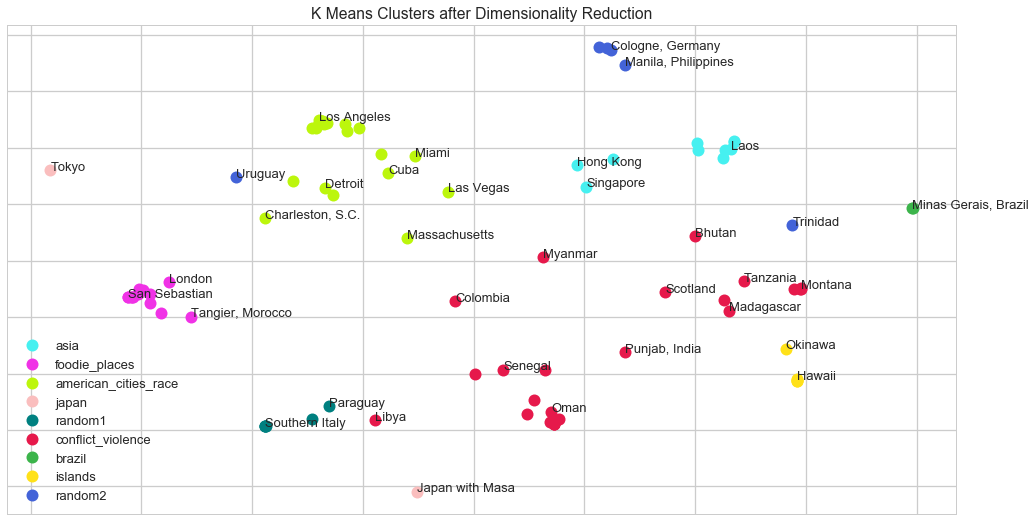

In [367]:
# example from http://brandonrose.org/clustering#Tf-idf-and-document-similarity
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(puk.episode_location))) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, loc='lower left')  #show legend with only 1 point

# mask overlapping labels

ann = []
for i in range(len(df)):
    ann.append(ax.annotate(df.iloc[i]['title'], xy = (df.iloc[i]['x'], df.iloc[i]['y']), size=13))

mask = np.zeros(fig.canvas.get_width_height(), bool)

fig.canvas.draw()

for a in ann:
    bbox = a.get_window_extent()
    x0 = int(bbox.x0)
    x1 = int(math.ceil(bbox.x1))
    y0 = int(bbox.y0)
    y1 = int(math.ceil(bbox.y1))

    s = np.s_[x0:x1+1, y0:y1+1]
    if np.any(mask[s]):
        a.set_visible(False)
    else:
        mask[s] = True  
        
plt.title("K Means Clusters after Dimensionality Reduction")
plt.show()

In [368]:
plt.close()

In [369]:
# perform KMeans clustering without dimensionality reduction 

num_clusters = 9

km = KMeans(n_clusters=num_clusters, random_state=42)

km.fit(tfs)

clusters = km.labels_.tolist()

# dictionary and df of episode content

episodes = { 'episodeID': list(puk.episodeID), 'episode_location': list(puk.episode_location), 'date': list(puk.air_date), 'cluster': clusters}

frame = pd.DataFrame(episodes, index = [clusters] , columns = ['episodeID', 'episode_location', 'date', 'cluster'])

print("Top words per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    episode_list = []
   
    for episode in frame.loc[i]['episode_location']:
        episode_list.append(episode)
    print("Cluster {} episodes, {} episodes:  ".format(i, len(episode_list)))
    print(', '.join(episode_list))

    print('') #add whitespace
    print('') #add whitespace

Top words per cluster:

Cluster 0 episodes, 4 episodes:  
Cologne, Germany, Trinidad, Minas Gerais, Brazil, Bahia, Brazil


Cluster 1 episodes, 15 episodes:  
Senegal, Los Angeles, Madagascar, Queens, New Jersey, Chicago, West Virginia, Los Angeles, Shanghai, Massachusetts, Houston, Jerusalem, Singapore, Pittsburgh, South Africa


Cluster 2 episodes, 19 episodes:  
Miami, Scotland, Southern Italy, Budapest, Rome, Tangier, Morocco, Las Vegas, Berlin, Colombia, Mississippi Delta, Cajun Mardi Gras, Hong Kong, Mexico City, Ethiopia, Bay Area, The Bronx, Nashville, London, Spain


Cluster 3 episodes, 12 episodes:  
Detroit, Manila, Philippines, Oman, Punjab, India, Libya, Russia, Armenia, Istanbul, Iran, Congo, Beirut, Sri Lanka


Cluster 4 episodes, 6 episodes:  
Uruguay, Paraguay, Marseille, Buenos Aires, French Alps, Seattle


Cluster 5 episodes, 3 episodes:  
Japan with Masa, Okinawa, Tokyo


Cluster 6 episodes, 15 episodes:  
Laos, Korea, Tbilisi, Georgia, Peru, Thailand, Myanmar, Char

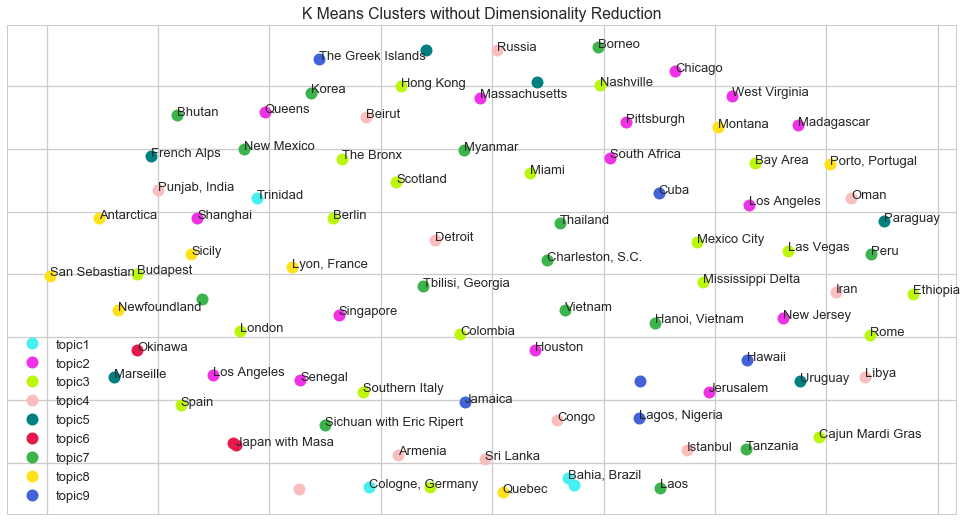

In [371]:
dist = 1 - cosine_similarity(tfs)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#46f0f0', 1: '#f032e6', 2: '#bcf60c', 3: '#fabebe', 4: '#008080',
                 5:'#e6194b', 6:'#3cb44b', 7:'#ffe119', 8:'#4363d8'}

#set up cluster names using a dict
cluster_names = {0: 'topic1', 
                 1: 'topic2', 
                 2: 'topic3', 
                 3: 'topic4', 
                 4: 'topic5',
                 5: 'topic6', 
                 6: 'topic7', 
                 7: 'topic8', 
                 8: 'topic9'}

# example from http://brandonrose.org/clustering#Tf-idf-and-document-similarity
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(puk.episode_location))) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, loc='lower left')  #show legend with only 1 point

# mask overlapping labels

ann = []
for i in range(len(df)):
    ann.append(ax.annotate(df.iloc[i]['title'], xy = (df.iloc[i]['x'], df.iloc[i]['y']), size=13))

mask = np.zeros(fig.canvas.get_width_height(), bool)

fig.canvas.draw()

for a in ann:
    bbox = a.get_window_extent()
    x0 = int(bbox.x0)
    x1 = int(math.ceil(bbox.x1))
    y0 = int(bbox.y0)
    y1 = int(math.ceil(bbox.y1))

    s = np.s_[x0:x1+1, y0:y1+1]
    if np.any(mask[s]):
        a.set_visible(False)
    else:
        mask[s] = True  
        
plt.title("K Means Clusters without Dimensionality Reduction")
plt.show()

## So what’s it all about, Tony???

*Parts Unknown* is frequently described as a ‘food show’, but it’s more than that. Yes, there is certainly a strong 'foodie' thread identified in this analysis but mostly food is a vehicle to connect people. This analysis shows what most fans of *Parts Unknown* inherantly knew. The show is not about food, but an exploration of the human experience and universal themes like war, violence, political upheaval, religion, race, and cultural heritage.

## And finally, planning my next vacation: the conflict-foodie index

>###  “I usually try to avoid clean, orderly countries without massive social problems.” 
>###    -Anthony Bourdain

I couldn't agree more. Clean countries are boring (except Japan), orderly countries are boring (except Japan), and massive social problems stem often stem from deep history and cultural complexity. In this vein, I used the themes I uncovered in *Parts Unknown* to identify place I'd like to go. While I like conflict zones, I also like to eat, so I defined `interesting_places` as those that had non-zero scores for the `conflict_area` topic and the `foodie` topic. Below I plotted a heat map of `interesting_places` correlated with whether I have visited (1= have been, 0= have not been). 

As per my strong suspicions, my next travel destination should be Iran, or possibly Oman (which I hear has some glamping opportunities). As always, Tony, thank you for the tip, and for encouraging millions of people like me to venture forth and explore the big scary world.

In [446]:
# add my travel data to the episode scores data

combined_data = pd.merge(episode_scores, puk, left_index=True, right_on='episode_location')
combined_data = merged[list(episode_scores.columns) + ['episode_location', 'j_j']]
combined_data.columns = list(combined_data.columns[:-1]) + ['have_been']

combined_data.set_index('episode_location', inplace=True)

In [448]:
# the foodie topic index

interesting_places = combined_data[['conflict_areas', 'foodie', 'have_been']][(
    combined_data.conflict_areas != 0)&(combined_data.foodie !=0)]

most_interesting_places = interesting_places.sort_values(by=
                                                         ['conflict_areas', 'foodie'], 
                                                         ascending=False).head(n=10)

In [449]:
# convert Y/N to int

mapping = {'Y': 1, 'N': 0}
most_interesting_places = most_interesting_places.applymap(lambda s: mapping.get(s) if s in mapping else s)

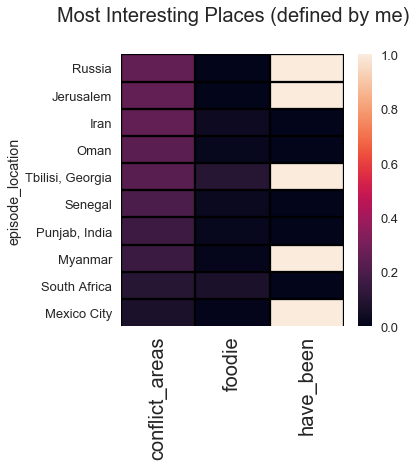

In [462]:
sns.set_context(context='talk', font_scale=1)
plt.figure(figsize=(5,5))
ax = sns.heatmap(most_interesting_places)
ax.hlines([range(len(most_interesting_places))], *ax.get_xlim())
ax.vlines([range(10)], *ax.get_ylim())
plt.title('Most Interesting Places (defined by me)', size=20, y=1.1)
plt.ylabel = ("Location")
plt.setp(ax.get_xticklabels(), rotation=90, size=20)

plt.show()

## Plotting iterations over num_clusters for both nmf and kmeans

/Users/jeff/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


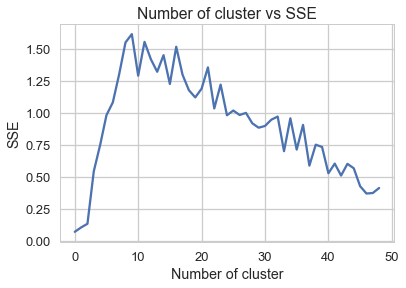

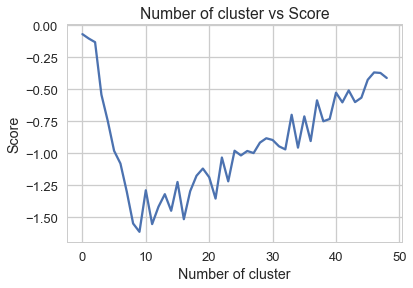

In [278]:
# iterate over range of possible cluster numbers to identify best value
num_clusters  = range(1, 50)

nmf_topics = [NMF(n_components=i) for i in num_clusters]
km = [KMeans(n_clusters=i) for i in num_clusters]

sse = {}
score = {}

for i in range(len(km)):
    W = nmf_topics[i].fit_transform(tfs)
    kmeans = km[i].fit(W)
    score[i] = kmeans.score(W)
    sse[i] = kmeans.inertia_ 

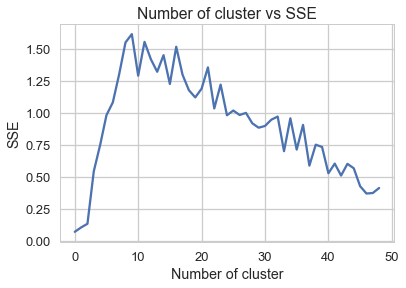

In [280]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Number of cluster vs SSE")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

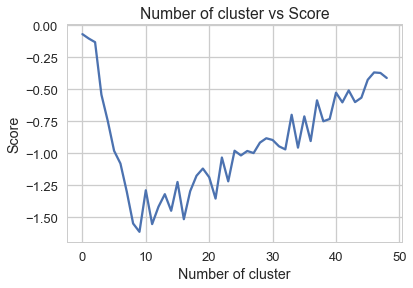

In [281]:
plt.figure()
plt.plot(list(score.keys()), list(score.values()))
plt.title("Number of cluster vs Score")
plt.xlabel("Number of cluster")
plt.ylabel("Score")
plt.show()

In [ ]:
use this reference!!!
https://nlpforhackers.io/recipe-text-clustering/